# Assignment 1
## Name - Pranav Gupta
## Roll No. - 2021101095

## 1. Own Calibration

#### 1.1 Identifying Chessboard's Internal Corners ####

In [4]:
import cv2
import numpy as np
import scipy
import matplotlib.pyplot as plt

#### Harris Corners approach ####

In [5]:
def Harris_Corners(img):
    img = cv2.imread(img)
    img = cv2.resize(img, [int(img.shape[1]/10), int(img.shape[0]/10)])
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = np.float32(gray)
    dst = cv2.cornerHarris(gray, 2, 3, 0.04)
    dst = cv2.dilate(dst, None)
    img[dst > 0.01 * dst.max()] = [0, 0, 255]
    cv2.imshow('Image showing Chessboard Corners',img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    corner_mask = (dst > 0.01 * dst.max()).astype(np.uint8)
    corner_coordinates = np.column_stack(np.where(corner_mask == 1))
    return corner_coordinates, gray

Harris_Corners('calib-object.jpg')

(array([[159, 141],
        [159, 142],
        [159, 143],
        ...,
        [350, 249],
        [350, 250],
        [350, 251]]),
 array([[179., 175., 178., ..., 169., 168., 167.],
        [174., 179., 177., ..., 168., 168., 169.],
        [174., 177., 179., ..., 168., 168., 168.],
        ...,
        [179., 182., 184., ..., 182., 182., 181.],
        [177., 178., 181., ..., 182., 183., 182.],
        [174., 175., 177., ..., 184., 182., 183.]], dtype=float32))

#### 1.2 Implementation of Camera Calibration Procedure from Scratch ####

##### Algorithm #####
Firstly, we take 12 points at random from the ChessBoard (we take those points that were detected earlier using Harris Corners), and then, based upon those points, find the corresponding Image Coordinates for those corners. The Mapping is x^T = PX^T, where x = 12 cross 3, X = 12 cross 4, while P is 3 cross 4. Using Pseudo Inverse technique (as done in the code), the Matrix P can be found. Once P is obtained, since P = [M|p4], M and p4 are found, consequently K, R and C are found.

In [6]:
class CalibrateCamera():

    def __init__(self, path):
        self.P = np.zeros((3, 4))
        self.K = np.zeros((3, 3))
        self.R = np.zeros((3, 3))
        self.M = np.zeros((3, 3))
        self.C = np.zeros((3, 1))
        self.path = path
        self.img_corners, self.gray = Harris_Corners(self.path)
        return



    def compute_mats(self):
        self.M = self.P[:, 0: 3]
        # self.K, self.R = scipy.linalg.rq(self.M)
        # self.K[0][1] = 00
        Z = np.dot(self.M, np.transpose(self.M))
        self.K[0][2] = Z[0][2]
        self.K[1][2] = Z[1][2]
        self.K[1][1] = (Z[1][1]-self.K[1][2]**2)**(1/2)
        self.K[0][1] = 0
        self.K[0][0] = (self.M[0][0]-self.K[0][2]**2)**(1/2)
        self.K[2][2] = 1
        self.R = np.dot(np.linalg.inv(self.K), self.M)
        p = self.P[:, 3]
        self.C = np.dot(-np.linalg.inv(self.M), p)
        return
    


    def compute_P(self, image_points, world_points):
        A = np.dot(np.transpose(world_points), np.linalg.pinv(np.transpose(world_points)))
        self.P = np.dot(np.dot(np.transpose(image_points), np.linalg.pinv(np.transpose(world_points))), np.linalg.inv(A))
        return



    def filter_coords(self):
        corners_filtered = cv2.goodFeaturesToTrack(self.gray, maxCorners = 140, qualityLevel=0.2, minDistance=10)
        self.corners_filtered = np.intp(corners_filtered)
        return


    def define_world_coords(self):                      # returns world coordinates of chessboard corners
        world_points = None
        if (self.path == 'calib-object.jpg'):
            world_points = np.array([[-0.14, 0.09, 0, 1], [-0.14, -0.09, 0, 1], [-0.08, 0.09, 0, 1], [-0.08, -0.09, 0, 1], [-0.08, -0.03, 0, 1],
[-0.08, 0.03, 0, 1], [0, 0.09, 0.14, 1], [0, -0.09, 0.14, 1], [0, 0.09, 0.08, 1], [0, -0.09, 0.08, 1], [0, 0.03, 0.08, 1], [0, -0.03, 0.08, 1]])
        else:
            world_points = np.array([[-0.06, 0.06, 0, 1], [0, 0.06, 0, 1], [0.06, 0.06, 0, 1], [-0.06, 0, 0, 1], [0, 0, 0, 1],
[0.06, 0, 0, 1], [-0.06, -0.06, 0, 1], [0, -0.06, 0, 1], [0.06, -0.06, 0, 1], [0, 0.2, 0.11, 1], [0.02, -0.02, 0, 1], [0.02, 0.02, 0, 1]])
        return world_points



    def define_image_coords(self):                # returns image coordinates of chessboard corners
        img_coords = None
        if (self.path == 'calib-object.jpg'):
            img_coords = np.array([[43, 173, 1],
                            [56, 346, 1],
                            [97, 166, 1],
                            [104, 324, 1],
                            [102, 274, 1],
                            [99, 222, 1],
                            [263, 175, 1],
                            [250, 349, 1],
                            [210, 167, 1],
                            [205, 325, 1],
                            [206, 224, 1],
                            [206, 276, 1]])
        else:
            img_coords = np.array([[80, 79, 1],
                            [106, 78, 1],
                            [136, 79, 1],
                            [77, 89, 1],
                            [107, 89, 1],
                            [139, 89, 1],
                            [74, 102, 1],
                            [108, 102, 1],
                            [143, 103, 1],
                            [105, 23, 1],
                            [118, 94, 1],
                            [118, 88, 1]])
            

        return img_coords
        


    def remap(self, world_points, image_points):
        temp = np.dot(self.P, np.transpose(world_points))
        temp1 = np.transpose(temp)
        print("reconstructed image coordinates = ", temp1)
        print("\n\n\noriginal image coordinates = ", image_points)

In [7]:
path = 'calib-object.jpg'
cam = CalibrateCamera(path=path)
cam.filter_coords()
world_points = cam.define_world_coords()
image_points = cam.define_image_coords()
cam.compute_P(image_points=image_points, world_points=world_points)
cam.compute_mats()
cam.remap(world_points=world_points, image_points=image_points)
print("P = ", cam.P)
print("K = ", cam.K)
print("R = ", cam.R)
print("C = ", cam.C)

reconstructed image coordinates =  [[ 53.30523067 176.85688759   1.        ]
 [ 54.01575699 342.09372969   1.        ]
 [ 96.50430474 163.90318389   1.        ]
 [ 97.21483106 329.14002599   1.        ]
 [ 96.97798895 274.06107862   1.        ]
 [ 96.74114685 218.98213125   1.        ]
 [251.98424301 179.40627031   1.        ]
 [252.69476933 344.64311241   1.        ]
 [210.03516894 165.35997401   1.        ]
 [210.74569526 330.59681611   1.        ]
 [210.27201105 220.43892138   1.        ]
 [210.50885315 275.51786875   1.        ]]



original image coordinates =  [[ 43 173   1]
 [ 56 346   1]
 [ 97 166   1]
 [104 324   1]
 [102 274   1]
 [ 99 222   1]
 [263 175   1]
 [250 349   1]
 [210 167   1]
 [205 325   1]
 [206 224   1]
 [206 276   1]]
P =  [[ 7.19984568e+02 -3.94736842e+00  6.99151235e+02  1.54458333e+02]
 [-2.15895062e+02 -9.17982456e+02  2.34104938e+02  2.29250000e+02]
 [ 1.67632942e-30  5.55111512e-17  6.66133815e-16  1.00000000e+00]]
K =  [[2.68325282e+01 0.00000000e+00 4.

#### 1.3 Overlay Wireframe using Camera Matrix ####

image =  [(53, 176), (54, 342), (154, 311), (252, 344), (251, 179), (154, 146)]


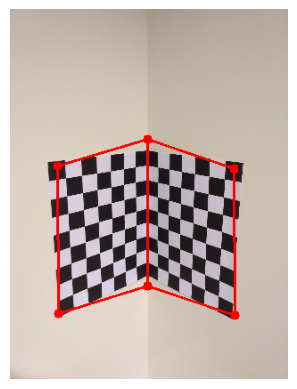

In [8]:
def wireframe_overlay(image, P, X):
    image_points = []

    for i in range(6):
        X_i = np.array([[X[i, 0], X[i, 1], X[i, 2], 1]]).T
        x_i = np.dot(P, X_i)
        x_i = x_i / x_i[2]
        image_points.append((int(x_i[0]), int(x_i[1])))


    print("image = ", image_points)
    image = cv2.imread(image)
    image = cv2.resize(image, [int(image.shape[1]/10), int(image.shape[0]/10)])
    for i in range(6):
        cv2.circle(image, image_points[i], 5, (0, 0, 255), -1)

    for i in range(5):
        cv2.line(image, image_points[i], image_points[i + 1], (0, 0, 255), 2)
    cv2.line(image, image_points[5], image_points[0], (0, 0, 255), 2)
    cv2.line(image, image_points[5], image_points[2], (0, 0, 255), 2)
    cv2.imshow("Wireframe Overlay", image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

world_coords = np.array([[-0.14, 0.09, 0, 1], [-0.14, -0.09, 0, 1], [0, -0.09, 0, 1], [0, -0.09, 0.14, 1], [0, 0.09, 0.14, 1], [0, 0.09, 0, 1]])
wireframe_overlay('calib-object.jpg', cam.P, world_coords)

##### Observations #####
The Wireframe Overlay approximates upto a great extent but is not able to find the corners of the Chessboard perfectly. But, by performing the above steps, it gives us a fair idea about the shap and corners of the Chessboard.

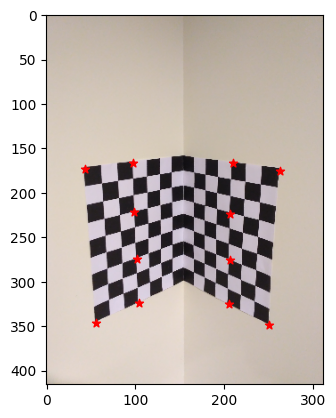

In [9]:
img = cv2.imread('calib-object.jpg')
img = cv2.resize(img, [312, 416])

# Selected image corner coordinates
# defined for 312*416 sized-image
img_coords = np.array([[43, 173, 1],
                        [56, 346, 1],
                        [97, 166, 1],
                        [104, 324, 1],
                        [102, 274, 1],
                        [99, 222, 1],
                        [263, 175, 1],
                        [250, 349, 1],
                        [210, 167, 1],
                        [205, 325, 1],
                        [206, 224, 1],
                        [206, 276, 1]])
# Plot the points on the image
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.scatter(img_coords[:, 0], img_coords[:, 1], c='r', marker='*')
plt.show()

#### 1.4 Rotation Angles Computation ###

In [10]:
cam.R = np.dot(np.linalg.inv(cam.K), cam.M)
norm = np.linalg.norm(cam.R)
temp = cam.R / norm
beta = np.arcsin(-temp[2][0])
alpha = np.arccos(temp[0][0]/np.cos(beta))
gamma = np.arcsin(temp[2][1]/np.cos(beta))
alpha, beta, gamma

(0.7710946820871318, -4.480295741040135e-32, 1.4836366345483431e-18)

The three rotation angles correspond to rotations about three axes typically denoted as X, Y, and Z. The rotation matrix can be expressed as a composition of rotations about these axes.
Pan: Rotation about the vertical axis (Z-axis).
Tilt: Rotation about the lateral axis (Y-axis).
Roll: Rotation about the longitudinal axis (X-axis).
These angles can be computed by the matrix given above in the code in the form of comments.

## 2 OpenCV Calibration ##

### 2.1 Camera Calibration using OpenCV ###

In [11]:
obj_points = []
img_points = []

# Generate object points for the chessboard pattern
corner_coordinates, gray = Harris_Corners('calib-object.jpg')


world_points = np.array([[-0.14, 0.09, 0], [-0.14, -0.09, 0], [-0.08, 0.09, 0], [-0.08, -0.09, 0], [-0.08, -0.03, 0],
[-0.08, 0.03, 0], [0, 0.09, 0.14], [0, -0.09, 0.14], [0, 0.09, 0.08], [0, -0.09, 0.08], [0, 0.03, 0.08], [0, -0.03, 0.08]], np.float32)
obj_points.append(world_points)

img_coords = np.array([[43, 173],
                        [56, 346],
                        [97, 166],
                        [104, 324],
                        [102, 274],
                        [99, 222],
                        [263, 175],
                        [250, 349],
                        [210, 167],
                        [205, 325],
                        [206, 224],
                        [206, 276]], np.float32)

img_points.append(img_coords)

# Perform camera calibration
ret, cameraMatrix, distCoeffs, rvecs, tvecs = cv2.calibrateCamera(obj_points, img_points, gray.shape[::-1], cam.K, np.array([]), flags = cv2.CALIB_USE_INTRINSIC_GUESS)
cameraMatrix, distCoeffs

(array([[ 31.22639105,   0.        , 130.06001611],
        [  0.        , 969.21971552, 137.03577727],
        [  0.        ,   0.        ,   1.        ]]),
 array([[-1.70319953e-02],
        [ 8.57917400e-05],
        [ 4.95072703e-04],
        [ 1.16769797e-03],
        [-1.20729528e-07]]))

#### Comparison of Intrinsic Camera Matrix as observed in 1.2 and 2.1 ####
K = [[2.68325282e+01 0.00000000e+00 4.65509156e-13]
    [0.00000000e+00 9.71651990e+02 1.04986953e-13]
    [0.00000000e+00 0.00000000e+00 1.00000000e+00]] as found in Part 1 while that found in Part 2 using OpenCV Inbuilt Functions is 
K = [[ 31.22639105,   0.        , 130.06001611],
    [  0.        , 969.21971552, 137.03577727],
    [  0.        ,   0.        ,   1.        ]].

##### Repeating of Overlay Experiment #####

image =  [(99, 604), (99, 604), (99, 604), (99, 604), (99, 604), (99, 604)]


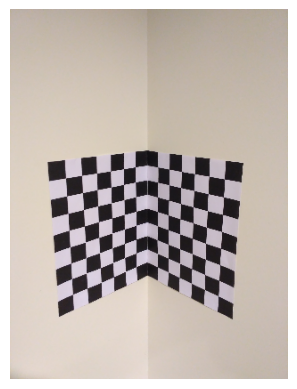

In [12]:
P = np.zeros((cameraMatrix.shape[0], cameraMatrix.shape[1]+1))
P[:, 0: 3] = cameraMatrix[:, :]
C = np.zeros((cam.C.shape[0], 1))
C[:, 0] = cam.C[:]
temp = np.dot(cameraMatrix, -C)
temp1 = np.array([])
for i in range(temp.shape[0]):
    temp1 = np.append(temp1, np.array([temp[i][0]]))
P[:, 3] = temp1

world_coords = np.array([[-0.08, 0.09, 0, 1], [-0.08, -0.09, 0, 1], [-0.08, -0.03, 0, 1], [-0.08, 0.03, 0, 1],
                         [0, 0.09, 0.08, 1], [0, -0.09, 0.08, 1], [0, 0.03, 0.08, 1], [0, -0.03, 0.08, 1]])
wireframe_overlay('calib-object.jpg', P, world_coords)

#### Observations for 2.1 ####
We observe that the overlay was defined only for the camera matrix corresponding to the image with reduced dimensions and when the camera matrix was formed for the complete image, then the wireframe overlay disappears. It, instead is reflective of the world origin of the Image w.r.t Image pixel coordinates.

### 2.2 Camera Calibration for assign1.jpg ###

In [13]:
path = 'assign1.jpg'
cam1 = CalibrateCamera(path=path)
cam1.filter_coords()
world_points = cam1.define_world_coords()
image_points = cam1.define_image_coords()
cam1.compute_P(image_points=image_points, world_points=world_points)
cam1.compute_mats()
cam1.remap(world_points=world_points, image_points=image_points)
print("P = ", cam1.P)
print("K = ", cam1.K)
print("R = ", cam1.R)
print("C = ", cam1.C)

reconstructed image coordinates =  [[ 76.11426237  78.18452381   1.        ]
 [107.26622316  78.43452381   1.        ]
 [138.41818394  78.68452381   1.        ]
 [ 76.59640523  89.91666667   1.        ]
 [107.74836601  90.16666667   1.        ]
 [138.9003268   90.41666667   1.        ]
 [ 77.07854809 101.64880952   1.        ]
 [108.23050887 101.89880952   1.        ]
 [139.38246965 102.14880952   1.        ]
 [105.          23.           1.        ]
 [118.29306723  94.16071429   1.        ]
 [117.97163866  86.33928571   1.        ]]



original image coordinates =  [[ 80  79   1]
 [106  78   1]
 [136  79   1]
 [ 77  89   1]
 [107  89   1]
 [139  89   1]
 [ 74 102   1]
 [108 102   1]
 [143 103   1]
 [105  23   1]
 [118  94   1]
 [118  88   1]]
P =  [[ 5.19199346e+02 -8.03571429e+00 -1.03747560e+01  1.07748366e+02]
 [ 4.16666667e+00 -1.95535714e+02 -2.55086580e+02  9.01666667e+01]
 [-1.86109715e-31 -4.44089210e-16 -1.33226763e-15  1.00000000e+00]]
K =  [[2.27859462e+01 0.00000000e+00 1.

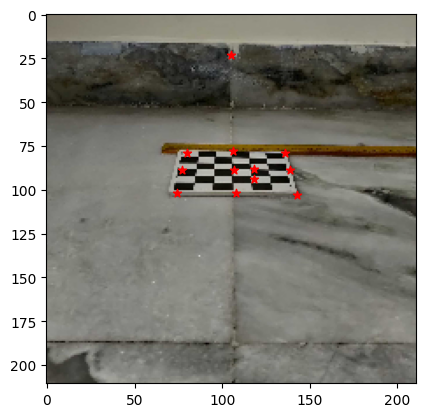

In [14]:
img = cv2.imread('assign1.jpg')
img = cv2.resize(img, [int(img.shape[1]/10), int(img.shape[0]/10)])

# Selected image corner coordinates
img_coords = np.array([[80, 79, 1],
                            [106, 78, 1],
                            [136, 79, 1],
                            [77, 89, 1],
                            [107, 89, 1],
                            [139, 89, 1],
                            [74, 102, 1],
                            [108, 102, 1],
                            [143, 103, 1],
                            [105, 23, 1],
                            [118, 94, 1],
                            [118, 88, 1]])


# Plot the points on the image
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.scatter(img_coords[:, 0], img_coords[:, 1], c='r', marker='*')
plt.show()

In [15]:
obj_points = []
img_points = []

corner_coordinates, gray = Harris_Corners('assign1.jpg')
world_points = np.array([[-0.06, 0.06, 0], [0, 0.06, 0], [0.06, 0.06, 0], [-0.06, 0, 0], [0, 0, 0], [0.06, 0, 0],
[-0.06, -0.06, 0], [0, -0.06, 0], [0.06, -0.06, 0], [0.01, 0.2, 0.115], [0.02, -0.02, 0], [0.02, 0.02, 0]], np.float32)
obj_points.append(world_points)

img_coords = np.array([[80, 79],
                        [106, 78],
                        [136, 79],
                        [77, 89],
                        [107, 89],
                        [139, 89],
                        [74, 102],
                        [108, 102],
                        [143, 103],
                        [105, 23],
                        [118, 94],
                        [118, 88]], np.float32)

img_points.append(img_coords)

# Perform camera calibration
ret, cameraMatrix, distCoeffs, rvecs, tvecs = cv2.calibrateCamera(obj_points, img_points, gray.shape[::-1], cam1.K, np.array([]), flags = cv2.CALIB_USE_INTRINSIC_GUESS)
cameraMatrix, distCoeffs

(array([[2.27859462e+01, 0.00000000e+00, 1.73902915e-14],
        [0.00000000e+00, 3.21435437e+02, 4.26676527e-13],
        [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]),
 array([[-6.23180517e-12],
        [-1.08230856e-09],
        [-4.76447409e-13],
        [-3.12244326e-13],
        [-1.92705678e-07]]))

image =  [(76, 78), (77, 101), (108, 101), (139, 102), (138, 78), (107, 78)]


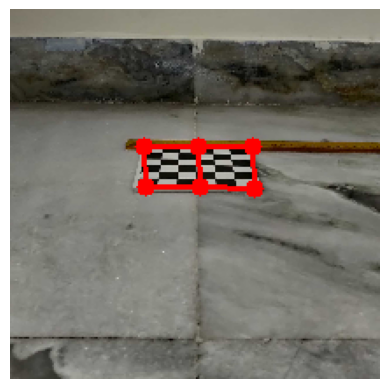

In [16]:
world_points = np.array([[-0.06, 0.06, 0], [-0.06, -0.06, 0], [0, -0.06, 0], [0.06, -0.06, 0], [0.06, 0.06, 0], [0, 0.06, 0]])
wireframe_overlay('assign1.jpg', cam1.P, world_points)

##### Observations #####
The Wireframe Overlay is almost perfect and is reflective of both corners and shape of the Chessboard. Reason it works in this case is that chessboard lies in x-y plane only here while in the calib-object.jpg case, chessbard had 3 dimensions and the wireframe approach could only approximate the solutions. 

image =  [(0, -419), (0, -419), (0, -419), (0, -419), (0, -419), (0, -419)]


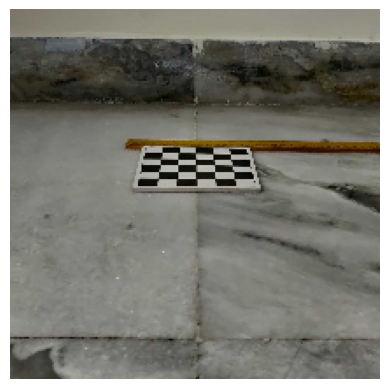

In [17]:
P = np.zeros((cameraMatrix.shape[0], cameraMatrix.shape[1]+1))
P[:, 0: 3] = cameraMatrix[:, :]
C = np.zeros((cam1.C.shape[0], 1))
C[:, 0] = cam1.C[:]
temp = np.dot(cameraMatrix, -C)
temp1 = np.array([])
for i in range(temp.shape[0]):
    temp1 = np.append(temp1, np.array([temp[i][0]]))
P[:, 3] = temp1

world_coords = np.array([[-0.08, 0.09, 0, 1], [-0.08, -0.09, 0, 1], [-0.08, -0.03, 0, 1], [-0.08, 0.03, 0, 1],
                         [0, 0.09, 0.08, 1], [0, -0.09, 0.08, 1], [0, 0.03, 0.08, 1], [0, -0.03, 0.08, 1]])
wireframe_overlay('assign1.jpg', P, world_coords)

### 2.3 World Origin Given Calibration Matrix ###

In [18]:
world_origin_1 = np.dot(cam.K, cam.C)
world_origin_1 /= world_origin_1[2]
world_origin_1

array([ 99.81983786, 604.95344102,   1.        ])

In [19]:
world_origin_2 = np.dot(cam1.K, cam1.C)
world_origin_2 /= world_origin_2[2]
world_origin_2

array([-4.75248605e-03, -4.19330790e+02,  1.00000000e+00])

#### Observations ####
Given the World Origin, We have Image Coordinates as x = K[I|C]X, where X = [0, 0, 0, 1]. The Matrix Multiplication of [I|C] and X leads to only C as the product. So, World Origin O = KC, which is computed above as nearly [100, 605] (in Image Pixel Coordinates). We expected this value only since after calibration, the Camera Matrix P and the World Coordinates product led to the Value [99, 604], meaning that the Wireframe is formed only at the Image Center. Thus. the Values are in conformation to each other. Similar Calculations hold for Image 2. The center for the image obtained is (-0.00475. -419). Now since -0.00475~0, our method correctly predicts the world origin of the image.

## 3 Moving the Chessboard ##

#### 3.1 Movement of assign1.jpg Chessboard ####

image =  [(128, 78), (128, 102), (160, 102), (191, 102), (190, 79), (159, 78)]


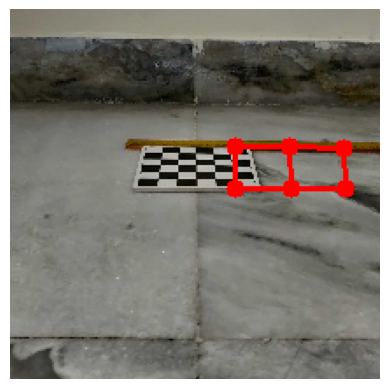

In [20]:
obj_points = []
img_points = []

world_points = np.array([[-0.06, 0.06, 0], [-0.06, -0.06, 0], [0, -0.06, 0], [0.06, -0.06, 0], [0.06, 0.06, 0], [0, 0.06, 0]])
world_points[:, 0] += 0.1
obj_points.append(world_points)

homogenous_world = np.ones((world_points.shape[0], world_points.shape[1]+1), np.float32)
homogenous_world[:, 0:3] = world_points
img_coords = np.transpose(np.dot(cam1.P, homogenous_world.T))
img_cor = np.zeros((img_coords.shape[0], img_coords.shape[1]-1), np.float32)
img_cor = img_coords[:, 0:2]
img_points.append(img_cor)

wireframe_overlay('assign1.jpg', cam1.P, world_points)

#### Observations ####
The Wireframe looks almost as expected because of the fact that Chessboard was displaced by 10cm towards the right, it's coordinates are almost as predicted by using the matrices. There exists some kind of angle deformations in the image due to which the ChessBoard's wireframe is not aptly represented according to the coordinates but more or less the wireframe almost takes the shape of the chessboard.

#### 3.2 Moving Pixels of Chessboard ####

##### Finding out Vanishing Point of the Image #####

In [21]:
x = np.array([74, 77, 80])
y = np.array([102, 89, 79])
slope1, intercept1, r1, p1, se1 = scipy.stats.linregress(x, y)

x = np.array([137, 138, 143])
y = np.array([80, 90, 102])
slope2, intercept2, r2, p2, se2 = scipy.stats.linregress(x, y)
x = (intercept2-intercept1) / (slope1-slope2)
y = (slope1*intercept2-intercept1*slope2) / (slope1-slope2)
x, y

(105.54435178165276, -19.42001516300228)

##### Algorithm #####
First of all, using the 2 sides of the chessboard, we find the straight lines representing the boundaries of the chessboard. This we do, by performing Linear Regression. Now, we iterate over all y-coordinates in the chessboard strip and in that iterate over each of the valeus of x by plugging values of y in the 2 straight lines. Then, the Numpy array gives us the pixels in the chessboard. We find out the World Coordinates of the Image, add 10cm along x-axis to the image, multiply it by P Matrix and find out updated image coordinates. Then, the pixels of the Image are set to that value of the Chessboard and then extended.

In [23]:
image = cv2.imread('assign1.jpg')
image = cv2.resize(image, [int(image.shape[1]/10), int(image.shape[0]/10)])

image_pts = []
for y in range(78, 103):
    x1 = int((y-intercept1)/slope1)
    x2 = int((y-intercept2)/slope2)
    for x in range(x1, x2+1):
        image_pts.append(np.array([x, y]))


image_np = np.ones((len(image_pts), 3))
for i in range(len(image_pts)):
    image_np[i][0] = image_pts[i][1]
    image_np[i][1] = image_pts[i][0]

    
world_map = np.dot(np.linalg.pinv(cam1.P), image_np.T).T
world_map[:, 0] /= world_map[:, 3]
world_map[:, 1] /= world_map[:, 3]
world_map[:, 2] /= world_map[:, 3]
world_map[:, 3] = 1

world_map[:, 1] -= 0.1
new_image = np.dot(cam1.P, world_map.T).T


pixels_arr = np.zeros((len(image_np), 3))
for i in range(len(image_np)):
    pixels_arr[i] = image[int(image_np[i][0]), int(image_np[i][1])]

for i in range(len(image_np)):
    image[int(new_image[i][0]), int(new_image[i][1])] = pixels_arr[i]


cv2.imshow("Updated", image)
cv2.waitKey(0)
cv2.destroyAllWindows()

We find that Overlay is observed above is not consistent with the Image obtained. We expected it to be consistent, but due to imperfections existing in the Image (Parallel Straight Lines intersecting at a common Vanishing Point), Radial Distortions, etc. the Wireframe obtained does not match with the displaced chessboard and hence does not truly represent the Displaced Chessboard. 

## Challenges Faced ##

1. The inbuilt findChessboardCorners function did not work as expected, due to the presence of distortions in the image and due to the fact that chessboard was aligned along perpendicular directions(walls) in the image. Some time was given and the Harris Corner's Approach was thoroughly studied and implemented.
2. Camera Calibration was not being done correctly in the beginning due to various issues in Matrix dimensions and size of image. Then, it was understood that size of image affects the image coordinates mapping.
3. Inbuilt cameraCalibrate() function does not work for non-planar rings. To make it work, a lot of time was devoted to study the CALIB_CB_INTRINSIC_GUESS flag which accepts the Initial Guess of Intrinsic Matrix and outputs Intrinsic Matrix for Non-Planar rings.
4. Concept of world origin and it's relationship between Wireframe Overlay was confusing in the beginning.
5. Finding Corners in assign1.jpg in 3D was difficult.
6. Movement of Chessboard and the projection of it's overlay was difficult and a lot of time had to be devoted to this task.
7. Movement of Actual Pixels of the Chessboard and the reorganisation of each of the pixels was a difficult task and it's embedding was a difficult task.